In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking, LSTM, Dense, TimeDistributed

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from hmmlearn import hmm
from collections import defaultdict

rc('font', family='Malgun Gothic')  

In [2]:
# 난수 시드 고정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
# --------------------------------------------------------------------------------
# 1) 데이터 로드 & 전처리 _datawizardd
# --------------------------------------------------------------------------------

data_dir = "hand_data"
files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

all_sequences = []
all_labels = []
max_len = 0

for file_name in files:
    csv_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(csv_path, encoding="cp949")
    df.sort_values(by='Time', inplace=True)

    # CSV 하나당 하나의 Gesture만 기록
    gesture_name = df['Gesture'].iloc[0]

    # Time별로 (ID=0~20) 좌표를 모아 (T, 63) 구성
    frames = []
    unique_times = df['Time'].unique()
    for t in unique_times:
        df_t = df[df['Time'] == t]
        row_data = []
        for landmark_id in range(21):
            sub = df_t[df_t['ID'] == landmark_id]
            if len(sub) == 0:
                row_data.extend([0.0, 0.0, 0.0])
            else:
                x_val = sub['X'].values[0]
                y_val = sub['Y'].values[0]
                z_val = sub['Z'].values[0]
                row_data.extend([x_val, y_val, z_val])
        frames.append(row_data)

    seq = np.array(frames)  # shape=(T, 63)
    if seq.shape[0] > max_len:
        max_len = seq.shape[0]

    all_sequences.append(seq)
    all_labels.append(gesture_name)

# 0-padding (뒤쪽)
padded_sequences = []
for seq in all_sequences:
    T_current = seq.shape[0]
    if T_current < max_len:
        pad_width = ((0, max_len - T_current), (0, 0))
        seq_padded = np.pad(seq, pad_width, mode='constant', constant_values=0.0)
    else:
        seq_padded = seq[:max_len]
    padded_sequences.append(seq_padded)

X = np.array(padded_sequences)  
y = np.array(all_labels)        

print("X.shape:", X.shape)  
print("y.shape:", y.shape)
print("Unique gestures:", np.unique(y))

X.shape: (2500, 135, 63)
y.shape: (2500,)
Unique gestures: ['감기(기침)' '결핵' '고혈압' '구토' '변비' '병' '상처' '선생님' '소변' '소화' '수술' '아프다' '약'
 '열나다' '영양' '운동' '잠' '저혈압' '주사' '참다' '처음' '추워요' '콧물감기' '피곤하다' '피부']


In [4]:
# --------------------------------------------------------------------------------
# 2) Train/Test 분할 _datawizardd
# --------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (2000, 135, 63) (2000,)
Test set: (500, 135, 63) (500,)


In [5]:
# --------------------------------------------------------------------------------
# 3) 스케일링(정규화) _datawizardd
# --------------------------------------------------------------------------------

N_train, T, D = X_train.shape
N_test = X_test.shape[0]

# StandardScaler는 2D 데이터에 대해 작동하므로 reshape
X_train_reshaped = X_train.reshape(N_train*T, D)
X_test_reshaped = X_test.reshape(N_test*T, D)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# 다시 3D로 복원
X_train_scaled = X_train_scaled.reshape(N_train, T, D)
X_test_scaled = X_test_scaled.reshape(N_test, T, D)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 135, 63)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 135, 63)           │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 135, 63)           │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 135)               │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 135, 64)           │          32,768 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 135, 32)           │          12,416 │ lstm[0][0], any[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 135, 32)           │           8,320 │ lstm_1[0][0], any[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 135, 64)           │          24,832 │ lstm_2[0][0], any[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 135, 63)           │           4,095 │ lstm_3[0][0], any[0][0]    │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,431 (322.00 KB)

 Trainable params: 82,431 (322.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.8961 - val_loss: 0.5249
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.4519 - val_loss: 0.3226
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.3157 - val_loss: 0.2622
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.2651 - val_loss: 0.2238
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.2337 - val_loss: 0.1945
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.2062 - val_loss: 0.1726
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.1850 - val_loss: 0.1554
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.1678 - val_loss: 0.1437
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.1571 - val_loss: 0.1388
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.1495 - val_loss: 0.1317


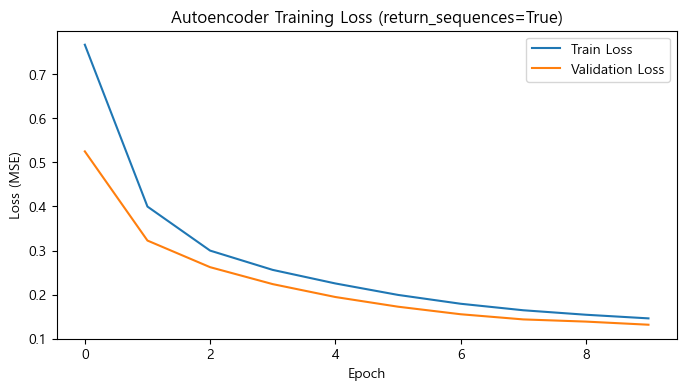

In [6]:
# --------------------------------------------------------------------------------
# 4) LSTM 오토인코더 (시점별 Latent 추출) _datawizardd
# --------------------------------------------------------------------------------
# 목표: 입력 (N, T, D) -> 인코더 -> (N, T, latent_dim)
#       디코더 -> (N, T, D)
# 여기서는 encoder 마지막 LSTM에서 return_sequences=True로
# "각 타임스텝마다 latent_dim"을 출력하게 함

latent_dim = 32

input_layer = keras.Input(shape=(T, D))

# 패딩된 0 구간 무시
x = Masking(mask_value=0.0)(input_layer)

# 인코더: return_sequences=True로 설정
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
encoded = LSTM(latent_dim, return_sequences=True, dropout=0.2)(x)
# => encoded.shape = (N, T, latent_dim)

# 디코더 (encoded -> 재구성)
# 여기서는 return_sequences=True
x = LSTM(latent_dim, return_sequences=True, dropout=0.2)(encoded)
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
decoded = TimeDistributed(Dense(D))(x)
# => decoded.shape = (N, T, D)

autoencoder = keras.Model(input_layer, decoded)

# 인코더 전용 모델(입력 -> encoded) 빼 두기
encoder = keras.Model(input_layer, encoded)

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=10,
    batch_size=8,
    validation_split=0.2,
    shuffle=True
)

# 학습 곡선
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss (return_sequences=True)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [7]:
# --------------------------------------------------------------------------------
# 5) 오토인코더 인코더 부분으로 시점별 Latent 시퀀스 추출 _datawizardd
# --------------------------------------------------------------------------------

latent_train = encoder.predict(X_train_scaled) 
latent_test  = encoder.predict(X_test_scaled)  

print("latent_train.shape:", latent_train.shape)  
print("latent_test.shape :", latent_test.shape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
latent_train.shape: (2000, 135, 32)
latent_test.shape : (500, 135, 32)


In [41]:
# --------------------------------------------------------------------------------
# 6) HMM 학습 (수정 예시)
# --------------------------------------------------------------------------------

gesture_dict_train = defaultdict(list)
for lat_seq, label in zip(latent_train, y_train):
    # lat_seq.shape = (T, latent_dim)
    gesture_dict_train[label].append(lat_seq)

gesture_models = {}
n_components = 5  # 숨겨진 상태 수(하이퍼파라미터)

for gesture_name, seq_list in gesture_dict_train.items():
    X_concat = np.concatenate(seq_list, axis=0)  # shape=(sum(T_i), latent_dim)
    lengths = [s.shape[0] for s in seq_list]

    # (A) init_params / params 설정
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type='diag',
        n_iter=500,
        tol=1e-2,
        random_state=42,
        init_params='mc',  # 'mc'로 하면 startprob/transmat은 자동초기화 안 함
        params='stmc'      # 학습 중 s, t, m, c 전부 업데이트
    )

    # (B) 수동으로 균등 초기화
    model.startprob_ = np.ones(n_components) / n_components
    model.transmat_ = np.ones((n_components, n_components)) / n_components

    # 피팅
    model.fit(X_concat, lengths)

    gesture_models[gesture_name] = model


Model is not converging.  Current: 1161760.4591351016 is not greater than 1161760.4735145802. Delta is -0.01437947852537036


In [36]:
# --------------------------------------------------------------------------------
# 6) HMM 학습 _datawizardd
# --------------------------------------------------------------------------------
# 시퀀스 단위로: 한 샘플 -> (T, latent_dim)
# Gesture별로 묶어서 HMM 훈련
# hmmlearn: fit(X_concat, lengths) 형태 사용
# - X_concat = 모든 시퀀스를 세로로 이어붙인 것 (sum of T_i, latent_dim)
# - lengths = 각 시퀀스 길이 목록 [T_1, T_2, ..., T_n]

gesture_dict_train = defaultdict(list)
for lat_seq, label in zip(latent_train, y_train):
    # lat_seq.shape = (T, latent_dim)
    gesture_dict_train[label].append(lat_seq)

gesture_models = {}
n_components = 5  # 숨겨진 상태 수(하이퍼파라미터)

for gesture_name, seq_list in gesture_dict_train.items():
    # seq_list = [ (T1, latent_dim), (T2, latent_dim), ... ]
    # concat
    X_concat = np.concatenate(seq_list, axis=0)  # shape=(sum(T_i), latent_dim)
    lengths = [s.shape[0] for s in seq_list]

    model = hmm.GaussianHMM(
        n_components=5,
        covariance_type='diag',
        n_iter=500,
        tol=1e-2,
        random_state=42,
        init_params='random',    # 완전 랜덤 초기화
        params='stmc'            # 학습 중에는 startprob/transmat/means/covars 전부 업데이트
    )
    model.fit(X_concat, lengths)
    gesture_models[gesture_name] = model



Model is not converging.  Current: 1302894.3937972162 is not greater than 1302894.8067542766. Delta is -0.4129570603836328


In [42]:
# --------------------------------------------------------------------------------
# 7) 테스트(분류) - HMM log-likelihood 비교 _datawizardd
# --------------------------------------------------------------------------------
def classify_hmm(sequence_2d):
    """
    sequence_2d: shape=(T, latent_dim)
    return: (best_label, best_score)
    """
    best_label = None
    best_score = -np.inf
    length = [sequence_2d.shape[0]]  # 단일 시퀀스 길이

    for gesture_name, model in gesture_models.items():
        score = model.score(sequence_2d, length)
        if score > best_score:
            best_score = score
            best_label = gesture_name

    return best_label, best_score

correct = 0
total = 0

for lat_seq, true_label in zip(latent_test, y_test):
    pred_label, pred_score = classify_hmm(lat_seq)
    if pred_label == true_label:
        correct += 1
    total += 1

acc = correct / total
print(f"HMM Test Accuracy: {acc:.4f}  ({correct}/{total})")

HMM Test Accuracy: 0.6180  (309/500)


In [43]:
# 예측 라벨 생성
y_pred = []
for lat_seq in latent_test:
    pred_label, _ = classify_hmm(lat_seq)  # classify_hmm 함수 사용
    y_pred.append(pred_label)

In [44]:
# classification_report 생성
report = classification_report(y_test, y_pred, digits=4, output_dict=True)

# Pandas 데이터프레임으로 변환
df_report = pd.DataFrame(report).transpose()

# 표 출력
df_report

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

,precision,recall,f1-score,support
감기(기침),0.800000,0.750000,0.774194,16.000
결핵,0.933333,0.777778,0.848485,18.000
고혈압,1.000000,0.800000,0.888889,25.000
구토,1.000000,0.545455,0.705882,11.000
변비,0.944444,0.566667,0.708333,30.000
병,0.900000,1.000000,0.947368,18.000
상처,0.265625,0.809524,0.400000,21.000
선생님,0.305556,0.846154,0.448980,13.000
소변,0.461538,0.947368,0.620690,19.000
소화,0.944444,1.000000,0.971429,17.000


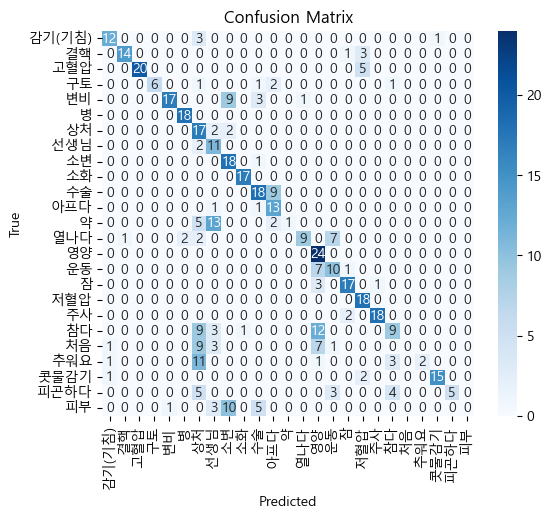

In [45]:
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

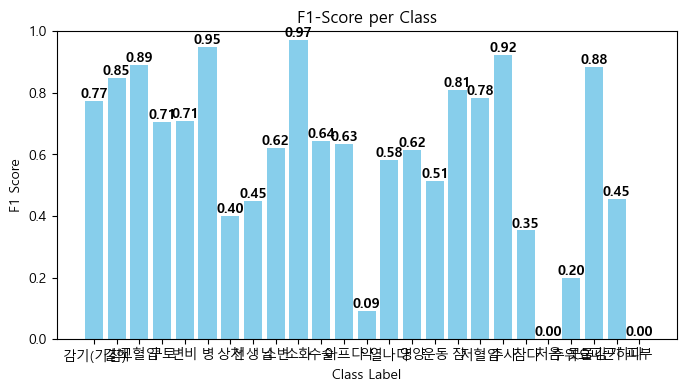

In [46]:
# 클래스별 F1 점수
f1_per_class = f1_score(y_test, y_pred, average=None, labels=labels)

plt.figure(figsize=(8, 4))
plt.bar(labels, f1_per_class, color='skyblue')
plt.title("F1-Score per Class")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim([0, 1])  # F1은 0~1 사이
for i, v in enumerate(f1_per_class):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

In [47]:
for gesture_name, model in gesture_models.items():
    print(f"{gesture_name}: {model.startprob_}")

처음: [0. 0. 0. 1. 0.]
참다: [0. 1. 0. 0. 0.]
주사: [0. 0. 0. 0. 1.]
피곤하다: [0. 0. 1. 0. 0.]
변비: [0. 0. 0. 1. 0.]
결핵: [1. 0. 0. 0. 0.]
구토: [0. 1. 0. 0. 0.]
고혈압: [0. 0. 0. 0. 1.]
운동: [0. 0. 0. 0. 1.]
병: [0. 0. 0. 1. 0.]
피부: [1. 0. 0. 0. 0.]
상처: [0. 0. 0. 1. 0.]
소화: [0. 0. 0. 1. 0.]
콧물감기: [0. 0. 0. 0. 1.]
소변: [0. 0. 0. 1. 0.]
선생님: [0. 0. 0. 1. 0.]
수술: [0. 0. 0. 0. 1.]
감기(기침): [0. 0. 0. 1. 0.]
약: [0. 0. 0. 0. 1.]
추워요: [0. 0. 0. 0. 1.]
저혈압: [0. 0. 0. 0. 1.]
아프다: [0. 0. 0. 0. 1.]
열나다: [0. 0. 1. 0. 0.]
잠: [0. 0. 0. 0. 1.]
영양: [0. 1. 0. 0. 0.]


In [48]:
for label in np.unique(y_test):
    print(f"Class {label}: {y_pred.count(label)} predictions")

Class 감기(기침): 15 predictions
Class 결핵: 15 predictions
Class 고혈압: 20 predictions
Class 구토: 6 predictions
Class 변비: 18 predictions
Class 병: 20 predictions
Class 상처: 64 predictions
Class 선생님: 36 predictions
Class 소변: 39 predictions
Class 소화: 18 predictions
Class 수술: 29 predictions
Class 아프다: 26 predictions
Class 약: 1 predictions
Class 열나다: 10 predictions
Class 영양: 54 predictions
Class 운동: 21 predictions
Class 잠: 21 predictions
Class 저혈압: 28 predictions
Class 주사: 19 predictions
Class 참다: 17 predictions
Class 처음: 0 predictions
Class 추워요: 2 predictions
Class 콧물감기: 16 predictions
Class 피곤하다: 5 predictions
Class 피부: 0 predictions


In [49]:
from collections import Counter
print("Test set class distribution:", Counter(y_test))

Test set class distribution: Counter({'참다': 34, '변비': 30, '수술': 27, '고혈압': 25, '영양': 24, '상처': 21, '잠': 21, '처음': 21, '약': 21, '열나다': 21, '주사': 20, '피부': 19, '소변': 19, '콧물감기': 18, '운동': 18, '결핵': 18, '병': 18, '저혈압': 18, '추워요': 18, '소화': 17, '피곤하다': 17, '감기(기침)': 16, '아프다': 15, '선생님': 13, '구토': 11})


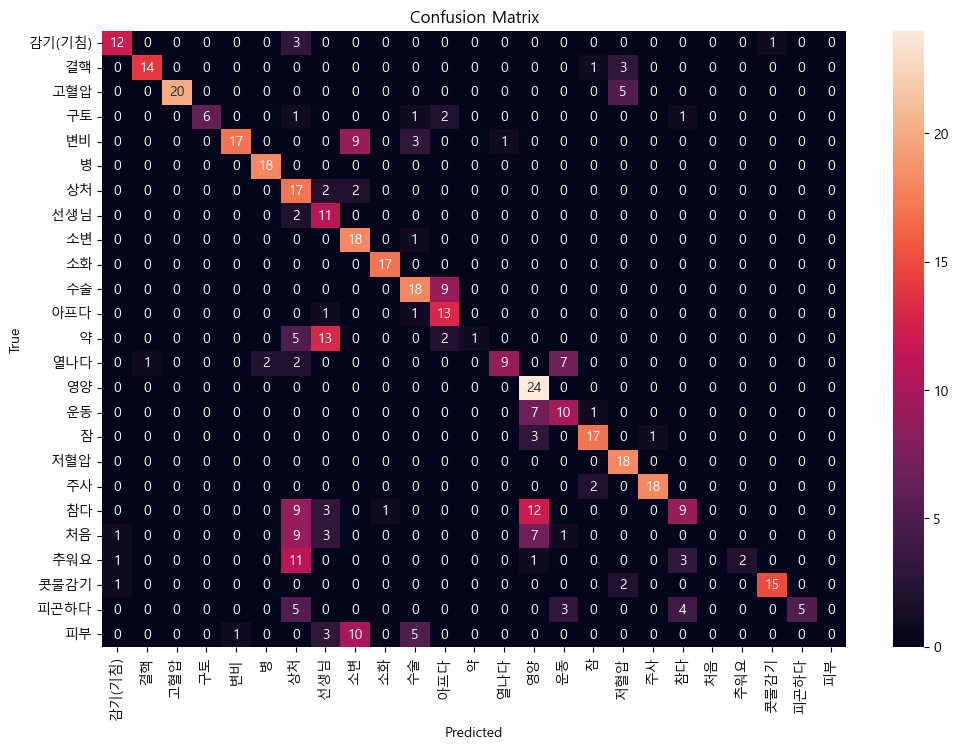

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [51]:
print("Classes in latent_train:", np.unique(y_train))
print("Classes in latent_test:", np.unique(y_test))

Classes in latent_train: ['감기(기침)' '결핵' '고혈압' '구토' '변비' '병' '상처' '선생님' '소변' '소화' '수술' '아프다' '약'
 '열나다' '영양' '운동' '잠' '저혈압' '주사' '참다' '처음' '추워요' '콧물감기' '피곤하다' '피부']
Classes in latent_test: ['감기(기침)' '결핵' '고혈압' '구토' '변비' '병' '상처' '선생님' '소변' '소화' '수술' '아프다' '약'
 '열나다' '영양' '운동' '잠' '저혈압' '주사' '참다' '처음' '추워요' '콧물감기' '피곤하다' '피부']


In [52]:
for gesture_name, model in gesture_models.items():
    print(f"{gesture_name}: startprob_ = {model.startprob_}")

처음: startprob_ = [0. 0. 0. 1. 0.]
참다: startprob_ = [0. 1. 0. 0. 0.]
주사: startprob_ = [0. 0. 0. 0. 1.]
피곤하다: startprob_ = [0. 0. 1. 0. 0.]
변비: startprob_ = [0. 0. 0. 1. 0.]
결핵: startprob_ = [1. 0. 0. 0. 0.]
구토: startprob_ = [0. 1. 0. 0. 0.]
고혈압: startprob_ = [0. 0. 0. 0. 1.]
운동: startprob_ = [0. 0. 0. 0. 1.]
병: startprob_ = [0. 0. 0. 1. 0.]
피부: startprob_ = [1. 0. 0. 0. 0.]
상처: startprob_ = [0. 0. 0. 1. 0.]
소화: startprob_ = [0. 0. 0. 1. 0.]
콧물감기: startprob_ = [0. 0. 0. 0. 1.]
소변: startprob_ = [0. 0. 0. 1. 0.]
선생님: startprob_ = [0. 0. 0. 1. 0.]
수술: startprob_ = [0. 0. 0. 0. 1.]
감기(기침): startprob_ = [0. 0. 0. 1. 0.]
약: startprob_ = [0. 0. 0. 0. 1.]
추워요: startprob_ = [0. 0. 0. 0. 1.]
저혈압: startprob_ = [0. 0. 0. 0. 1.]
아프다: startprob_ = [0. 0. 0. 0. 1.]
열나다: startprob_ = [0. 0. 1. 0. 0.]
잠: startprob_ = [0. 0. 0. 0. 1.]
영양: startprob_ = [0. 1. 0. 0. 0.]


In [53]:
for cls in ['선생님', '잠', '피부', '처음']:
    print(f"{cls} 데이터 개수: {len([label for label in y_train if label == cls])}")

선생님 데이터 개수: 87
잠 데이터 개수: 79
피부 데이터 개수: 81
처음 데이터 개수: 79


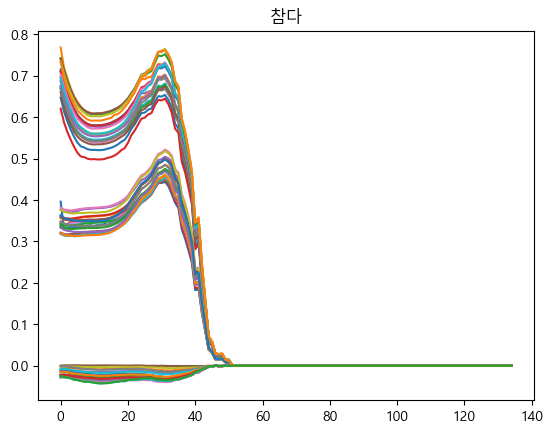

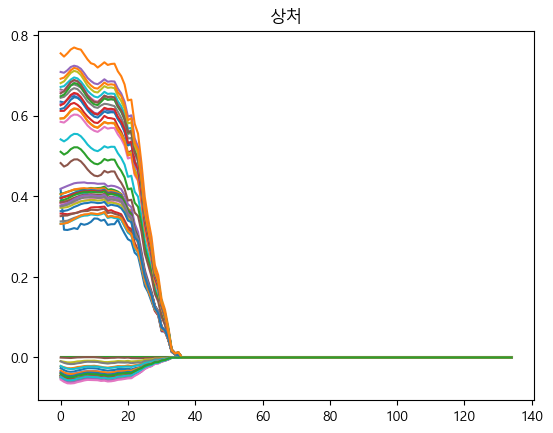

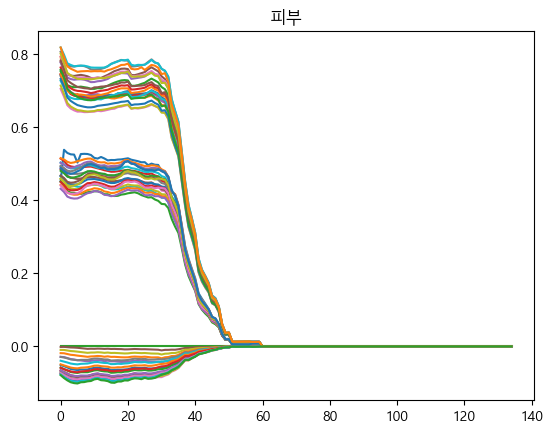

In [21]:
import matplotlib.pyplot as plt

for cls in ['참다', '상처', '피부']:
    class_data = X_train[np.array(y_train) == cls]
    plt.plot(class_data.mean(axis=0))  # 평균 값 시각화
    plt.title(cls)
    plt.show()